In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Make plots larger
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [3]:
# AWS Configuration
AWS_REGION = 'us-east-1'
S3_STAGING_DIR = 's3://manila-dengue-raw-data-pollywag/athena-results/'  # Change if needed
DATABASE = 'dengue_db'

# Create Athena connection
conn = connect(
    s3_staging_dir=S3_STAGING_DIR,
    region_name=AWS_REGION,
    cursor_class=PandasCursor
)

print(f"✅ Connected to Athena in region: {AWS_REGION}")
print(f"📂 Using database: {DATABASE}")

✅ Connected to Athena in region: us-east-1
📂 Using database: dengue_db


In [4]:
# Query to load all data from the view
query = """
SELECT 
    date,
    year,
    month,
    day,
    rainfall,
    tmax,
    tmin,
    ave_temp,
    rh,
    dengue_cases,
    rainfall_lag7,
    rainfall_lag14,
    rainfall_lag21,
    ave_temp_lag7,
    ave_temp_lag14,
    ave_temp_lag21,
    dengue_cases_lag7,
    dengue_cases_lag14,
    dengue_cases_lag21,
    rainfall_roll_mean_7d,
    ave_temp_roll_mean_7d,
    dengue_cases_roll_mean_7d,
    rainfall_roll_mean_14d,
    ave_temp_roll_mean_14d,
    dengue_cases_roll_mean_14d,
    temp_range,
    rain_temp_interaction,
    humidity_temp_interaction,
    week_of_year,
    quarter,
    is_rainy_season,
    season_name,
    risk_level
FROM dengue_db.weather_features_view
ORDER BY date
"""

# Execute query and load into DataFrame
print("⏳ Loading data from Athena...")
df = pd.read_sql(query, conn)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

print(f"✅ Data loaded successfully!")
print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\n📋 First 5 rows:")
df.head()

⏳ Loading data from Athena...
✅ Data loaded successfully!
📊 Shape: 1095 rows × 33 columns
📅 Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00

📋 First 5 rows:


,date,year,month,day,rainfall,tmax,tmin,ave_temp,rh,dengue_cases,...,ave_temp_roll_mean_14d,dengue_cases_roll_mean_14d,temp_range,rain_temp_interaction,humidity_temp_interaction,week_of_year,quarter,is_rainy_season,season_name,risk_level
0,2021-01-01,2021,1,1,0.0,28.2,23.5,25.85,65.0,8,...,25.8500,8.000000,4.7,0.00,1680.25,53,1,0,Dry,Low
1,2021-01-02,2021,1,2,0.0,30.5,24.5,27.50,68.0,4,...,26.6750,6.000000,6.0,0.00,1870.00,53,1,0,Dry,Low
2,2021-01-03,2021,1,3,33.6,26.3,22.7,24.50,87.0,2,...,25.9500,4.666667,3.6,823.20,2131.50,53,1,0,Dry,Low
3,2021-01-04,2021,1,4,0.7,32.2,25.0,28.60,73.0,6,...,26.6125,5.000000,7.2,20.02,2087.80,1,1,0,Dry,Low
4,2021-01-05,2021,1,5,0.0,29.9,24.4,27.15,77.0,4,...,26.7200,4.800000,5.5,0.00,2090.55,1,1,0,Dry,Low


In [5]:
# Basic statistics
print("=" * 80)
print("📊 SUMMARY STATISTICS")
print("=" * 80)

summary = df[['dengue_cases', 'ave_temp', 'rainfall', 'rh']].describe()
print(summary)

print("\n" + "=" * 80)
print("🌧️  SEASONAL COMPARISON")
print("=" * 80)

seasonal = df.groupby('season_name').agg({
    'dengue_cases': ['mean', 'sum', 'min', 'max'],
    'rainfall': ['mean', 'sum'],
    'ave_temp': 'mean'
}).round(2)

print(seasonal)

print("\n" + "=" * 80)
print("⚠️  RISK LEVEL DISTRIBUTION")
print("=" * 80)

risk_dist = df['risk_level'].value_counts().sort_index()
print(risk_dist)

📊 SUMMARY STATISTICS
       dengue_cases     ave_temp     rainfall           rh
count   1095.000000  1095.000000  1095.000000  1095.000000
mean       6.055708    28.633562     6.240913    71.919635
std        5.295612     1.382950    16.464827     8.499324
min        0.000000    23.900000     0.000000    51.000000
25%        2.000000    27.700000     0.000000    65.500000
50%        5.000000    28.750000     0.000000    73.000000
75%        8.000000    29.500000     3.500000    78.000000
max       40.000000    32.500000   206.900000    94.000000

🌧️  SEASONAL COMPARISON
            dengue_cases               rainfall         ave_temp
                    mean   sum min max     mean     sum     mean
season_name                                                     
Dry                 4.59  2921   0  24     2.10  1334.7    28.52
Rainy               8.08  3710   0  40    11.98  5499.1    28.79

⚠️  RISK LEVEL DISTRIBUTION
risk_level
Low    1095
Name: count, dtype: int64


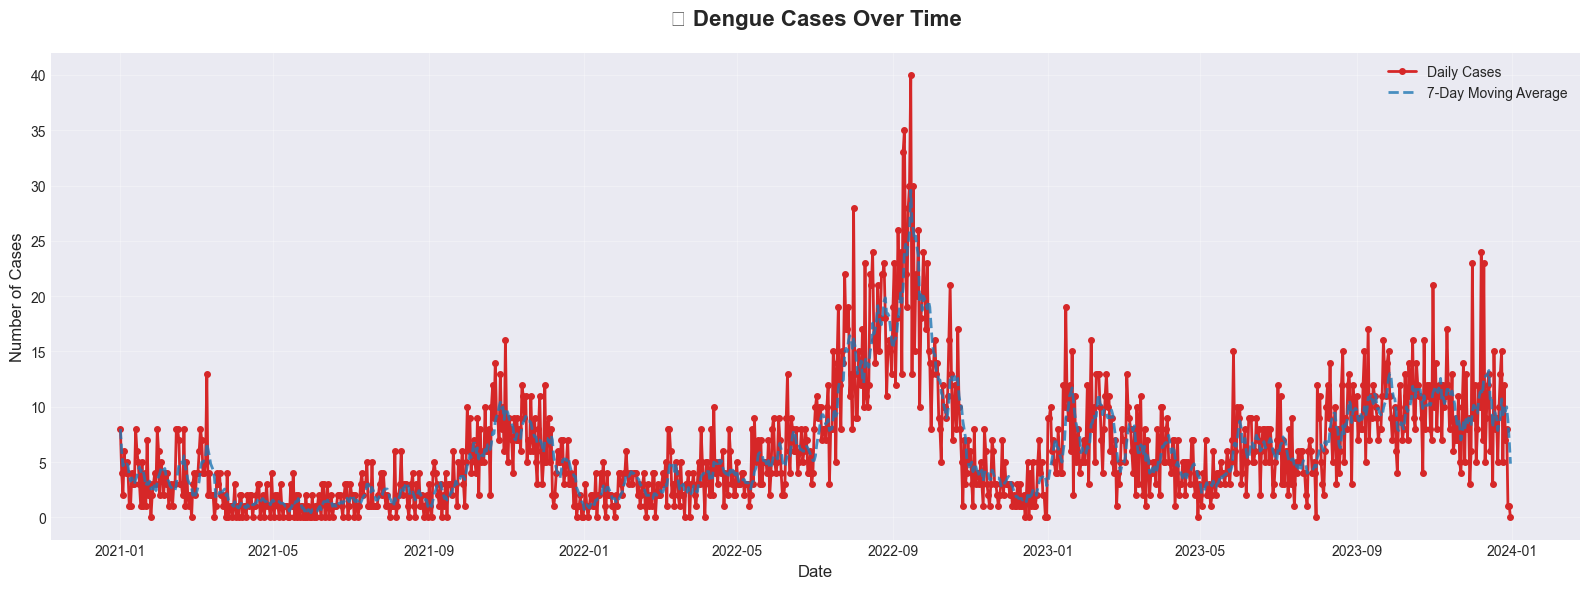

📊 Peak cases: 40 on 2022-09-15
📉 Average daily cases: 6.1


In [6]:
# Create time series plot
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df['date'], df['dengue_cases'], 
        color='#d62728', linewidth=2, marker='o', markersize=4,
        label='Daily Cases')

# Add 7-day rolling average
ax.plot(df['date'], df['dengue_cases_roll_mean_7d'], 
        color='#1f77b4', linewidth=2, linestyle='--',
        label='7-Day Moving Average', alpha=0.8)

ax.set_title('📈 Dengue Cases Over Time', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Cases', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Peak cases: {df['dengue_cases'].max()} on {df.loc[df['dengue_cases'].idxmax(), 'date'].date()}")
print(f"📉 Average daily cases: {df['dengue_cases'].mean():.1f}")

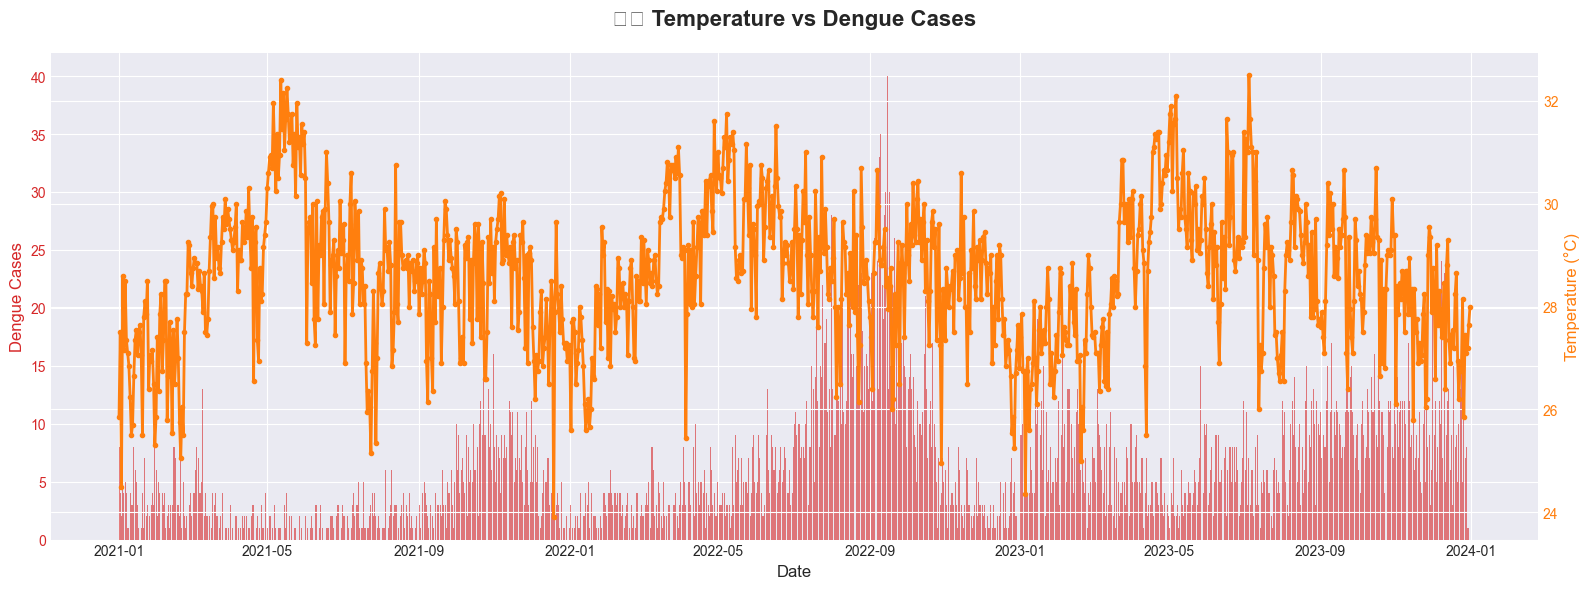

📊 Correlation between temperature and dengue cases: -0.077


In [7]:
# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot dengue cases (bars)
color = '#d62728'
ax1.bar(df['date'], df['dengue_cases'], alpha=0.6, color=color, label='Dengue Cases')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Dengue Cases', color=color, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for temperature
ax2 = ax1.twinx()
color = '#ff7f0e'
ax2.plot(df['date'], df['ave_temp'], color=color, linewidth=2, 
         marker='o', markersize=3, label='Average Temperature')
ax2.set_ylabel('Temperature (°C)', color=color, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('🌡️ Temperature vs Dengue Cases', fontsize=16, fontweight='bold', pad=20)
fig.tight_layout()
plt.show()

# Calculate correlation
corr = df[['ave_temp', 'dengue_cases']].corr().iloc[0, 1]
print(f"📊 Correlation between temperature and dengue cases: {corr:.3f}")

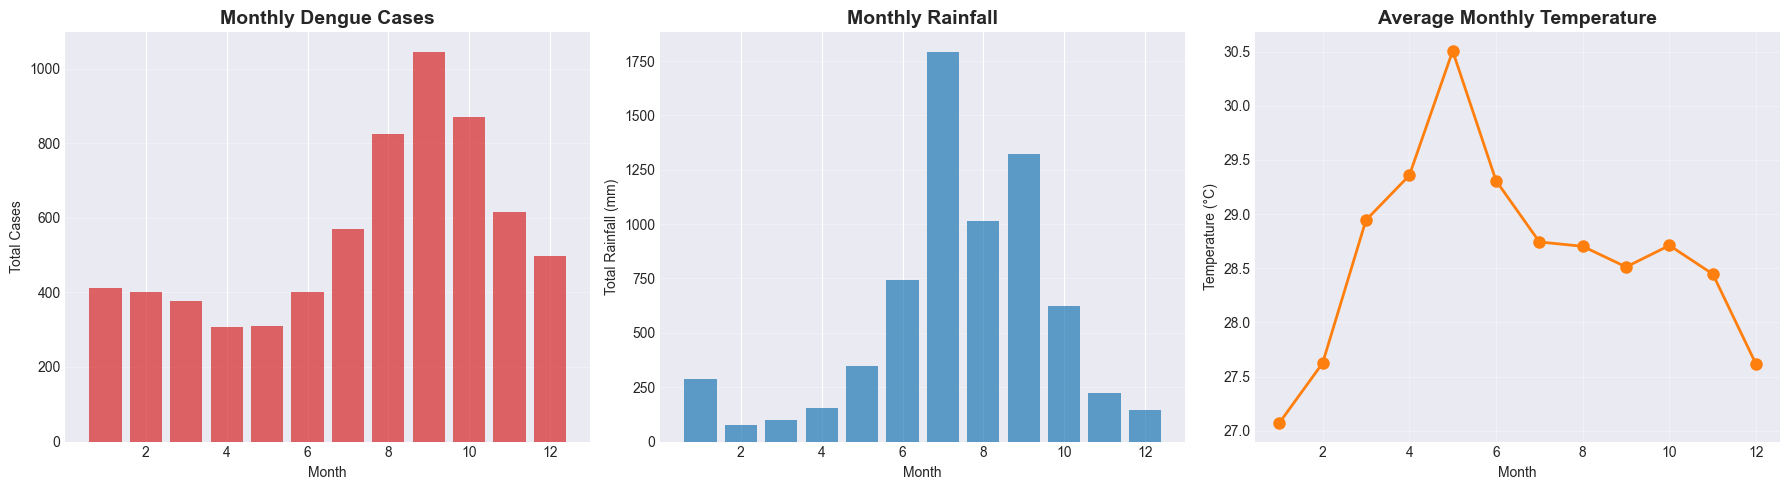

📅 Month with highest cases: 9
🌧️  Month with most rainfall: 7


In [8]:
# Monthly aggregation
monthly = df.groupby('month').agg({
    'dengue_cases': 'sum',
    'rainfall': 'sum',
    'ave_temp': 'mean'
}).reset_index()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Monthly dengue cases
axes[0].bar(monthly['month'], monthly['dengue_cases'], color='#d62728', alpha=0.7)
axes[0].set_title('Monthly Dengue Cases', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Cases')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Monthly rainfall
axes[1].bar(monthly['month'], monthly['rainfall'], color='#1f77b4', alpha=0.7)
axes[1].set_title('Monthly Rainfall', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Rainfall (mm)')
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Monthly temperature
axes[2].plot(monthly['month'], monthly['ave_temp'], 
             marker='o', color='#ff7f0e', linewidth=2, markersize=8)
axes[2].set_title('Average Monthly Temperature', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📅 Month with highest cases:", monthly.loc[monthly['dengue_cases'].idxmax(), 'month'])
print("🌧️  Month with most rainfall:", monthly.loc[monthly['rainfall'].idxmax(), 'month'])

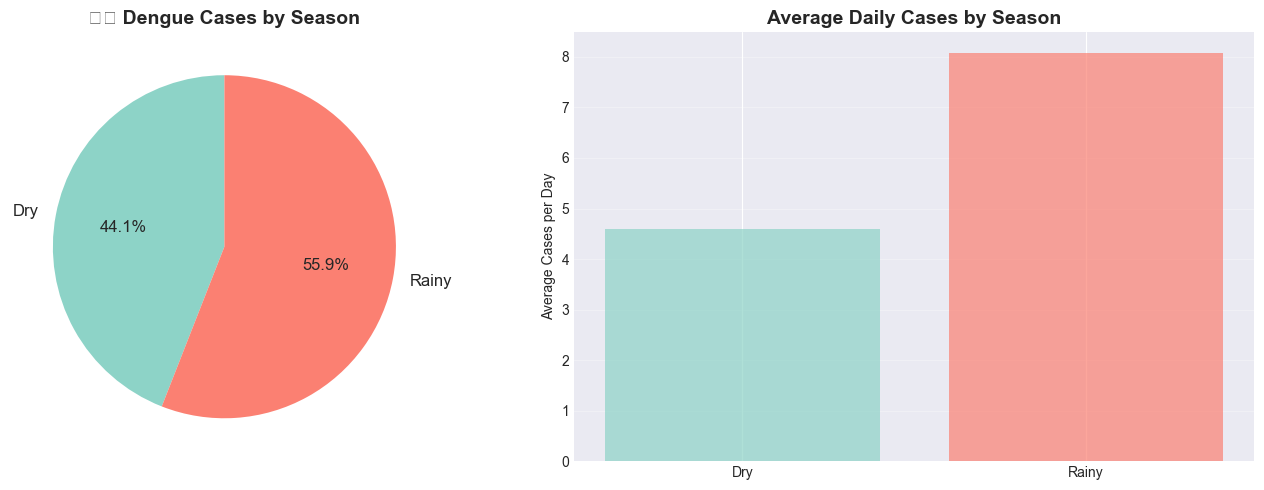


📊 Seasonal Comparison:
            dengue_cases       rainfall ave_temp
                     sum  mean      sum     mean
season_name                                     
Dry                 2921  4.59   1334.7    28.52
Rainy               3710  8.08   5499.1    28.79


In [9]:
# Season comparison
seasonal_stats = df.groupby('season_name').agg({
    'dengue_cases': ['sum', 'mean'],
    'rainfall': 'sum',
    'ave_temp': 'mean'
}).round(2)

# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cases by season (pie chart)
season_totals = df.groupby('season_name')['dengue_cases'].sum()
colors = ['#8dd3c7', '#fb8072']
axes[0].pie(season_totals.values, labels=season_totals.index, autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 12})
axes[0].set_title('🌧️ Dengue Cases by Season', fontsize=14, fontweight='bold')

# Plot 2: Average cases per day by season (bar chart)
season_avg = df.groupby('season_name')['dengue_cases'].mean()
axes[1].bar(season_avg.index, season_avg.values, color=colors, alpha=0.7)
axes[1].set_title('Average Daily Cases by Season', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Cases per Day')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Seasonal Comparison:")
print(seasonal_stats)

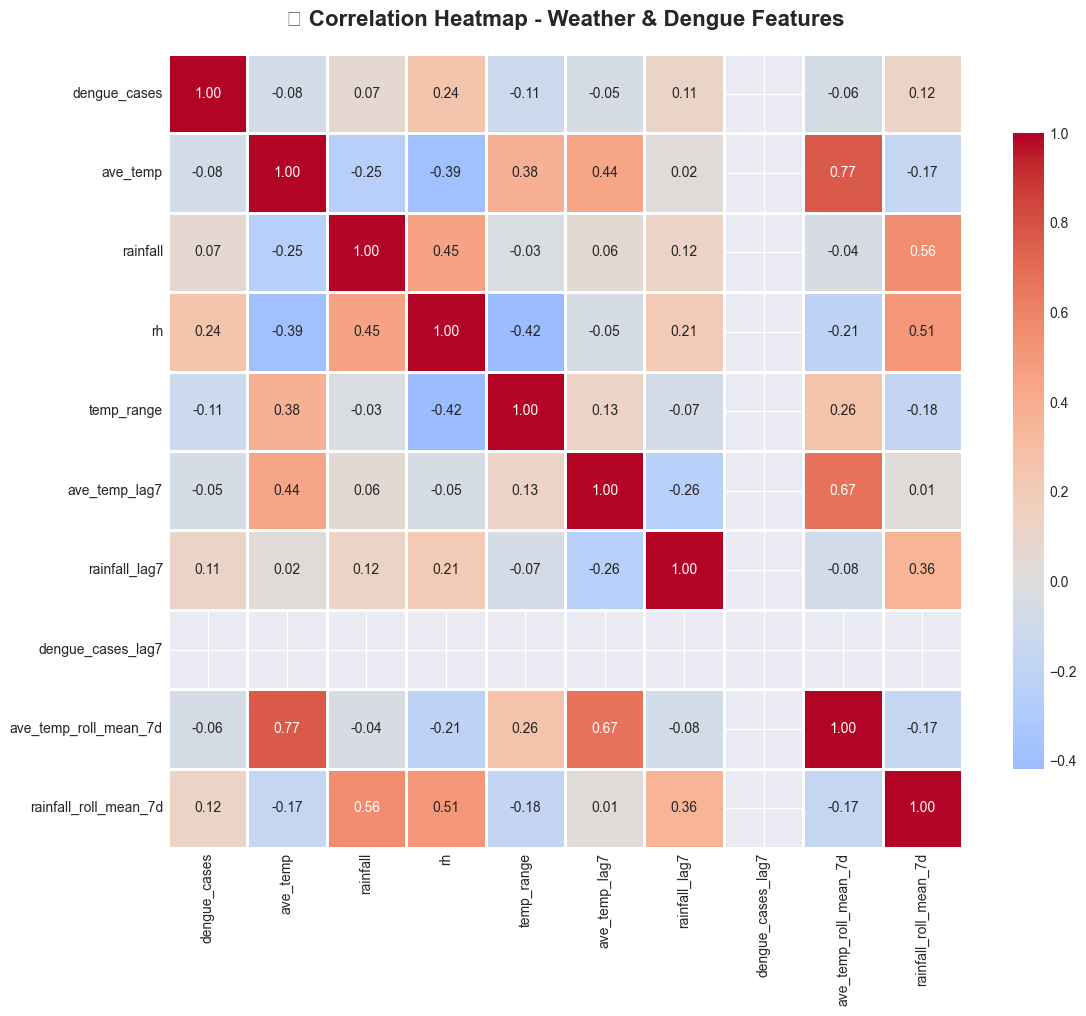

📊 Top correlations with dengue cases:
rh                       0.242606
rainfall_roll_mean_7d    0.124659
rainfall_lag7            0.111768
rainfall                 0.067241
ave_temp_lag7           -0.051036
Name: dengue_cases, dtype: float64


In [10]:
# Select numeric columns for correlation
corr_cols = ['dengue_cases', 'ave_temp', 'rainfall', 'rh', 'temp_range',
             'ave_temp_lag7', 'rainfall_lag7', 'dengue_cases_lag7',
             'ave_temp_roll_mean_7d', 'rainfall_roll_mean_7d']

# Calculate correlation matrix
corr_matrix = df[corr_cols].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('🔥 Correlation Heatmap - Weather & Dengue Features', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print top correlations with dengue cases
print("📊 Top correlations with dengue cases:")
dengue_corr = corr_matrix['dengue_cases'].sort_values(ascending=False)
print(dengue_corr[1:6])  # Exclude self-correlation

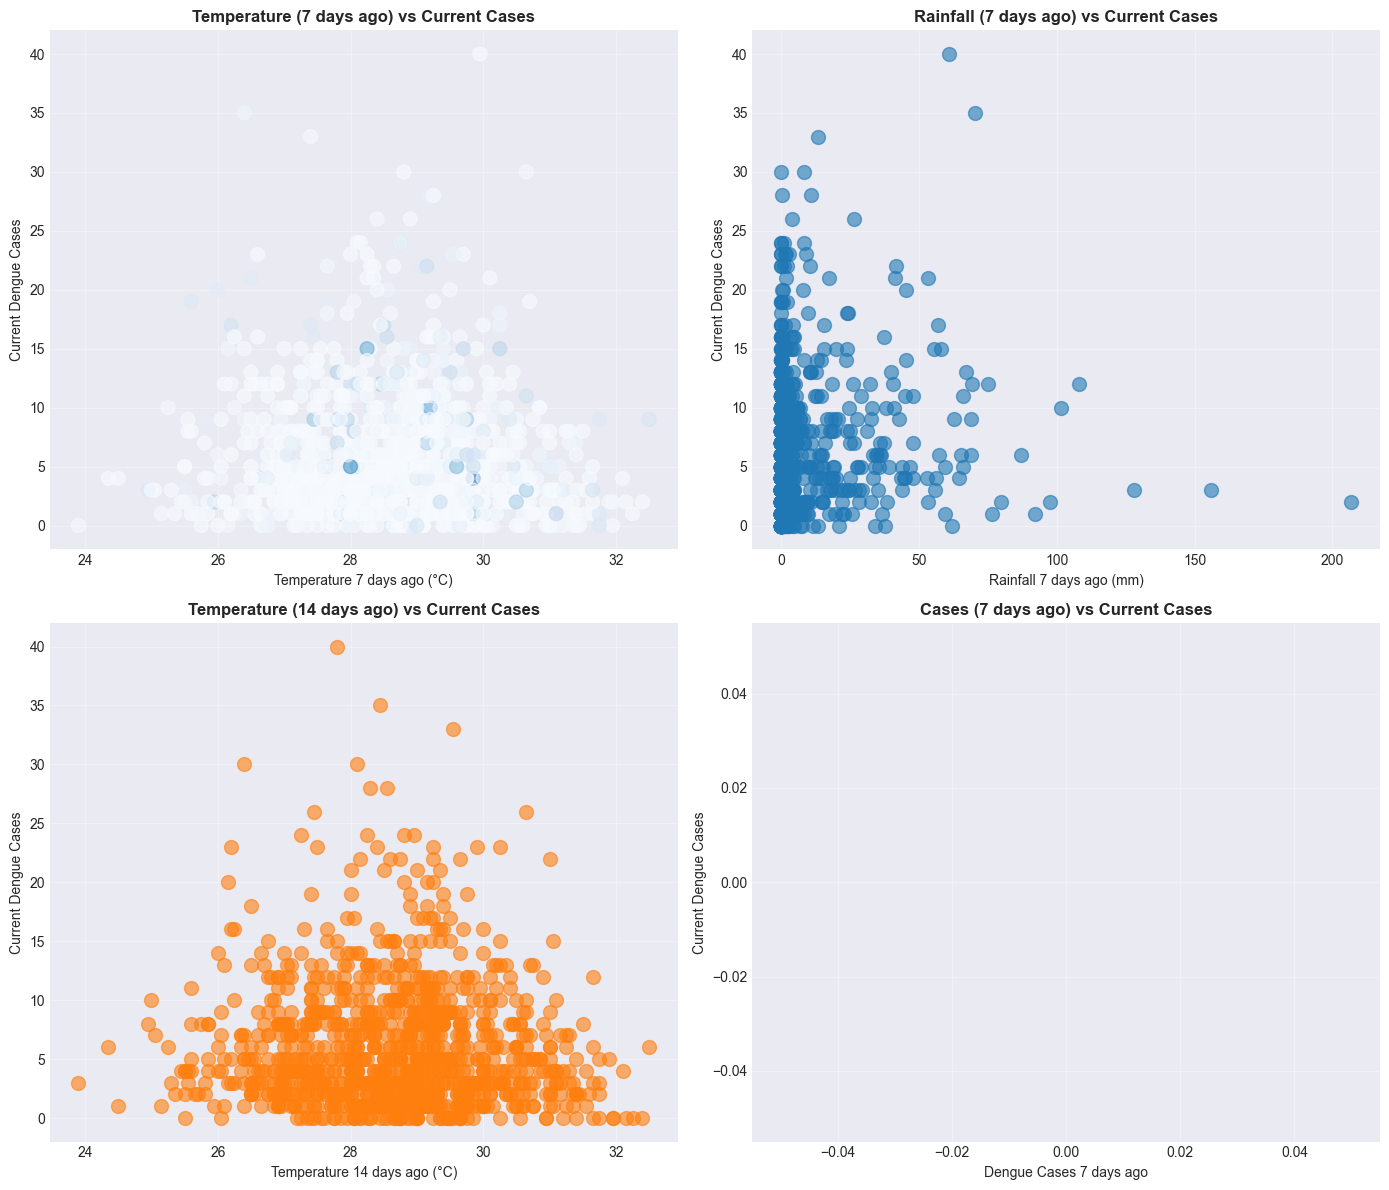

📊 Lag Feature Correlations with Current Cases:
ave_temp_lag7       -0.051036
rainfall_lag7        0.111768
dengue_cases_lag7         NaN
Name: dengue_cases, dtype: float64


In [11]:
# Filter rows with valid lag data
df_lag = df[df['ave_temp_lag7'].notna()].copy()

# Create scatter plots for lag features
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 7-day temperature lag
axes[0, 0].scatter(df_lag['ave_temp_lag7'], df_lag['dengue_cases'], 
                   alpha=0.6, s=100, c=df_lag['rainfall'], cmap='Blues')
axes[0, 0].set_title('Temperature (7 days ago) vs Current Cases', fontweight='bold')
axes[0, 0].set_xlabel('Temperature 7 days ago (°C)')
axes[0, 0].set_ylabel('Current Dengue Cases')
axes[0, 0].grid(True, alpha=0.3)

# 7-day rainfall lag
axes[0, 1].scatter(df_lag['rainfall_lag7'], df_lag['dengue_cases'], 
                   alpha=0.6, s=100, color='#1f77b4')
axes[0, 1].set_title('Rainfall (7 days ago) vs Current Cases', fontweight='bold')
axes[0, 1].set_xlabel('Rainfall 7 days ago (mm)')
axes[0, 1].set_ylabel('Current Dengue Cases')
axes[0, 1].grid(True, alpha=0.3)

# 14-day temperature lag
axes[1, 0].scatter(df_lag['ave_temp_lag14'], df_lag['dengue_cases'], 
                   alpha=0.6, s=100, color='#ff7f0e')
axes[1, 0].set_title('Temperature (14 days ago) vs Current Cases', fontweight='bold')
axes[1, 0].set_xlabel('Temperature 14 days ago (°C)')
axes[1, 0].set_ylabel('Current Dengue Cases')
axes[1, 0].grid(True, alpha=0.3)

# 7-day cases lag
axes[1, 1].scatter(df_lag['dengue_cases_lag7'], df_lag['dengue_cases'], 
                   alpha=0.6, s=100, color='#d62728')
axes[1, 1].set_title('Cases (7 days ago) vs Current Cases', fontweight='bold')
axes[1, 1].set_xlabel('Dengue Cases 7 days ago')
axes[1, 1].set_ylabel('Current Dengue Cases')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print lag correlations
print("📊 Lag Feature Correlations with Current Cases:")
lag_corr = df_lag[['ave_temp_lag7', 'rainfall_lag7', 'dengue_cases_lag7', 'dengue_cases']].corr()['dengue_cases']
print(lag_corr[:-1])

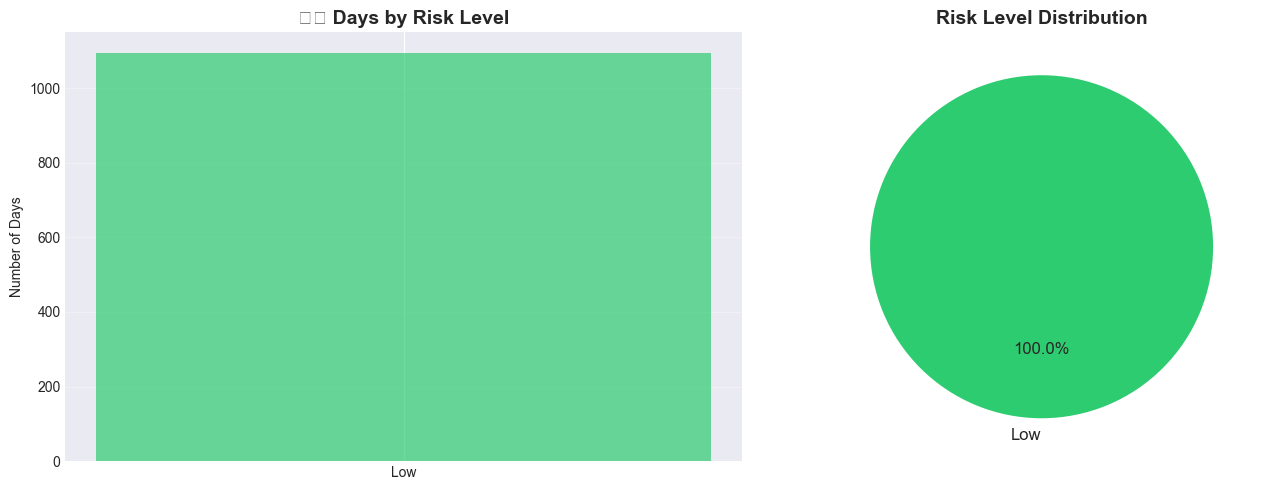

⚠️ Risk Level Summary:
  Low: 1095 days (100.0%)
  Medium: 0 days (0.0%)
  High: 0 days (0.0%)


In [12]:
# Risk level distribution
risk_counts = df['risk_level'].value_counts()

# Create bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Count of days by risk level
colors_risk = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}
risk_colors = [colors_risk[level] for level in risk_counts.index]

axes[0].bar(risk_counts.index, risk_counts.values, color=risk_colors, alpha=0.7)
axes[0].set_title('⚠️ Days by Risk Level', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Days')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Pie chart
axes[1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
            startangle=90, colors=risk_colors, textprops={'fontsize': 12})
axes[1].set_title('Risk Level Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print risk level stats
print("⚠️ Risk Level Summary:")
for level in ['Low', 'Medium', 'High']:
    count = risk_counts.get(level, 0)
    pct = (count / len(df)) * 100
    print(f"  {level}: {count} days ({pct:.1f}%)")

In [16]:
# Create interactive time series with Plotly
fig = go.Figure()

# Add dengue cases
fig.add_trace(go.Scatter(
    x=df['date'], 
    y=df['dengue_cases'],
    mode='lines+markers',
    name='Dengue Cases',
    line=dict(color='#d62728', width=2),
    marker=dict(size=6)
))

# Add temperature (secondary y-axis)
fig.add_trace(go.Scatter(
    x=df['date'], 
    y=df['ave_temp'],
    mode='lines',
    name='Temperature',
    line=dict(color='#ff7f0e', width=2),
    yaxis='y2'
))

# Add rainfall (bars)
fig.add_trace(go.Bar(
    x=df['date'],
    y=df['rainfall'],
    name='Rainfall',
    marker_color='#1f77b4',
    opacity=0.3,
    yaxis='y3'
))

# Update layout with multiple y-axes
fig.update_layout(
    title='📊 Interactive Dashboard - Manila Dengue Analysis',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Dengue Cases', side='left'),
    yaxis2=dict(title='Temperature (°C)', side='right', overlaying='y'),
    yaxis3=dict(title='Rainfall (mm)', side='right', overlaying='y', position=0.95),
    hovermode='x unified',
    height=600,
    legend=dict(x=0.01, y=0.99)
)

fig.show()

print("💡 Tip: Hover over the chart to see details! Use toolbar to zoom and pan.")

💡 Tip: Hover over the chart to see details! Use toolbar to zoom and pan.


In [14]:
# Create output directory
import os
os.makedirs('analysis_results', exist_ok=True)

# Export summary statistics
summary_stats = df[['dengue_cases', 'ave_temp', 'rainfall', 'rh']].describe()
summary_stats.to_csv('analysis_results/summary_statistics.csv')

# Export monthly aggregation
monthly.to_csv('analysis_results/monthly_summary.csv', index=False)

# Export seasonal comparison
seasonal_comparison = df.groupby('season_name').agg({
    'dengue_cases': ['count', 'sum', 'mean', 'min', 'max'],
    'rainfall': ['sum', 'mean'],
    'ave_temp': 'mean'
})
seasonal_comparison.to_csv('analysis_results/seasonal_comparison.csv')

# Export correlation matrix
corr_matrix.to_csv('analysis_results/correlation_matrix.csv')

print("✅ Results exported to 'analysis_results/' folder:")
print("   📄 summary_statistics.csv")
print("   📄 monthly_summary.csv")
print("   📄 seasonal_comparison.csv")
print("   📄 correlation_matrix.csv")

✅ Results exported to 'analysis_results/' folder:
   📄 summary_statistics.csv
   📄 monthly_summary.csv
   📄 seasonal_comparison.csv
   📄 correlation_matrix.csv


In [15]:
print("=" * 80)
print("🎯 KEY INSIGHTS FROM ANALYSIS")
print("=" * 80)

# 1. Overall statistics
total_cases = df['dengue_cases'].sum()
avg_daily_cases = df['dengue_cases'].mean()
peak_cases = df['dengue_cases'].max()
peak_date = df.loc[df['dengue_cases'].idxmax(), 'date'].date()

print(f"\n📊 Overall Statistics:")
print(f"   • Total cases: {total_cases}")
print(f"   • Average daily cases: {avg_daily_cases:.1f}")
print(f"   • Peak cases: {peak_cases} on {peak_date}")

# 2. Seasonal comparison
rainy_avg = df[df['season_name'] == 'Rainy']['dengue_cases'].mean()
dry_avg = df[df['season_name'] == 'Dry']['dengue_cases'].mean()

print(f"\n🌧️  Seasonal Patterns:")
print(f"   • Rainy season avg: {rainy_avg:.1f} cases/day")
print(f"   • Dry season avg: {dry_avg:.1f} cases/day")
print(f"   • Difference: {abs(rainy_avg - dry_avg):.1f} cases/day ({((rainy_avg/dry_avg - 1) * 100):.1f}% higher)" if rainy_avg > dry_avg else f"   • Dry season has {abs(rainy_avg - dry_avg):.1f} more cases/day")

# 3. Correlations
temp_corr = df[['ave_temp', 'dengue_cases']].corr().iloc[0, 1]
rain_corr = df[['rainfall', 'dengue_cases']].corr().iloc[0, 1]

print(f"\n🔗 Key Correlations:")
print(f"   • Temperature vs Cases: {temp_corr:.3f}")
print(f"   • Rainfall vs Cases: {rain_corr:.3f}")

# 4. Lag feature importance
if df['ave_temp_lag7'].notna().sum() > 0:
    lag7_corr = df[df['ave_temp_lag7'].notna()][['ave_temp_lag7', 'dengue_cases']].corr().iloc[0, 1]
    print(f"\n⏰ Lag Features (Predictive Power):")
    print(f"   • 7-day temperature lag correlation: {lag7_corr:.3f}")

# 5. Risk distribution
high_risk_days = (df['risk_level'] == 'High').sum()
high_risk_pct = (high_risk_days / len(df)) * 100

print(f"\n⚠️  Risk Assessment:")
print(f"   • High risk days: {high_risk_days} ({high_risk_pct:.1f}%)")
print(f"   • Medium risk days: {(df['risk_level'] == 'Medium').sum()}")
print(f"   • Low risk days: {(df['risk_level'] == 'Low').sum()}")

print("\n" + "=" * 80)

🎯 KEY INSIGHTS FROM ANALYSIS

📊 Overall Statistics:
   • Total cases: 6631
   • Average daily cases: 6.1
   • Peak cases: 40 on 2022-09-15

🌧️  Seasonal Patterns:
   • Rainy season avg: 8.1 cases/day
   • Dry season avg: 4.6 cases/day
   • Difference: 3.5 cases/day (76.0% higher)

🔗 Key Correlations:
   • Temperature vs Cases: -0.077
   • Rainfall vs Cases: 0.067

⏰ Lag Features (Predictive Power):
   • 7-day temperature lag correlation: -0.051

⚠️  Risk Assessment:
   • High risk days: 0 (0.0%)
   • Medium risk days: 0
   • Low risk days: 1095

